In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import  train_test_split
import pathlib
from Constants import *

In [2]:
train_dataset = keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 4857 files belonging to 4 classes.


In [3]:
test_dataset = keras.preprocessing.image_dataset_from_directory(
    VALIDATION_PATH,
    shuffle = True,
    image_size = (image_size, image_size),
    batch_size = BATCH_SIZE
)

Found 1311 files belonging to 4 classes.


In [4]:
class_names = test_dataset.class_names
print(class_names)
num_classes = len(class_names)
print(num_classes)

['glioma', 'meningioma', 'notumor', 'pituitary']
4


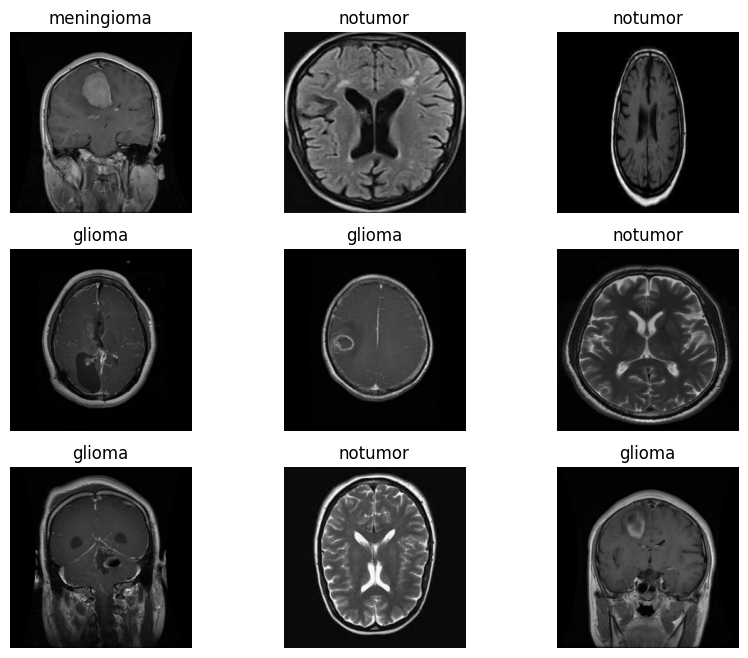

In [5]:
plt.figure(figsize = (10, 8))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_size = int(0.85 * len(train_dataset))
val_size = int(0.15 * len(train_dataset))
test_size = int(1 * len(test_dataset))

In [7]:
train_set = train_dataset.take(train_size)
val_set = train_dataset.skip(train_size)
test_set = test_dataset.take(test_size)

In [8]:
print(len(train_set),'\n',len(test_set),'\n',len(val_set))

258 
 82 
 46


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
resize_and_rescale = keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size, image_size),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [11]:
augmented_data = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape = (image_size, image_size,
                                     3)),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.3),
    layers.RandomFlip("horizontal_and_vertical")
])

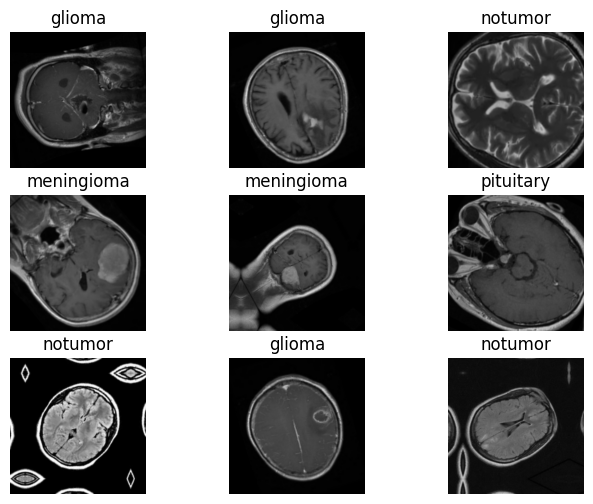

In [12]:
plt.figure(figsize = (8, 6))
for images, label in train_set.take(1):
    for i in range(9):
        augmented_images = augmented_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.title(class_names[label[i]])
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE, image_size, image_size, 3)

model = keras.Sequential([
    resize_and_rescale,
    augmented_data,
    layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(num_classes, activation = 'softmax'),    
])

model.build(input_shape = input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (16, 127, 127, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        18464     
                                                      

In [16]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [17]:
%%time

history = model.fit(train_set,
                    validation_data = val_set,
                    batch_size = BATCH_SIZE,
                    epochs = 30,
                    verbose = 1
                    )

Epoch 1/30


258/258 [==============================] - 508s 2s/step - loss: 1.1821 - accuracy: 0.4516 - val_loss: 1.0293 - val_accuracy: 0.5652
Epoch 2/30
258/258 [==============================] - 468s 2s/step - loss: 0.9938 - accuracy: 0.5812 - val_loss: 0.8875 - val_accuracy: 0.6296
Epoch 3/30
258/258 [==============================] - 478s 2s/step - loss: 0.8983 - accuracy: 0.6286 - val_loss: 0.8753 - val_accuracy: 0.6529
Epoch 4/30
258/258 [==============================] - 633s 2s/step - loss: 0.8266 - accuracy: 0.6567 - val_loss: 0.7890 - val_accuracy: 0.6886
Epoch 5/30
258/258 [==============================] - 630s 2s/step - loss: 0.7894 - accuracy: 0.6827 - val_loss: 0.9001 - val_accuracy: 0.6228
Epoch 6/30
258/258 [==============================] - 679s 3s/step - loss: 0.7541 - accuracy: 0.7001 - val_loss: 0.8352 - val_accuracy: 0.6406
Epoch 7/30
258/258 [==============================] - 563s 2s/step - loss: 0.7433 - accuracy: 0.7064 - val_loss: 0.6916 - val_accuracy: 0.6982
Epoch 8/30

In [18]:
loss = model.evaluate(test_set)
loss

82/82 [==============================] - 38s 422ms/step - loss: 0.4177 - accuracy: 0.8482


[0.4176890552043915, 0.8482074737548828]

In [19]:
history = history.history

In [20]:
acc = history['accuracy']
val_acc = history['val_accuracy']

loss = history['loss']
val_loss = history['val_loss']

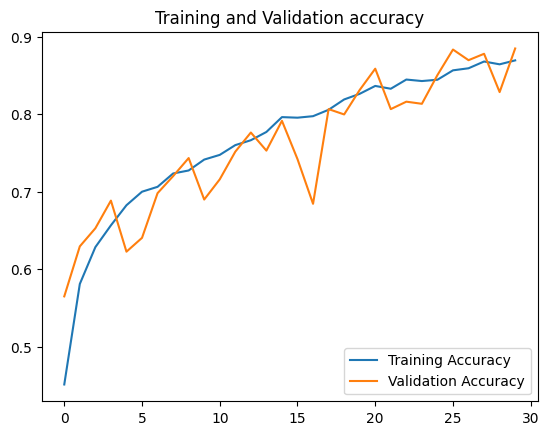

In [21]:
plt.plot(acc, label = "Training Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Training and Validation accuracy")
plt.show()

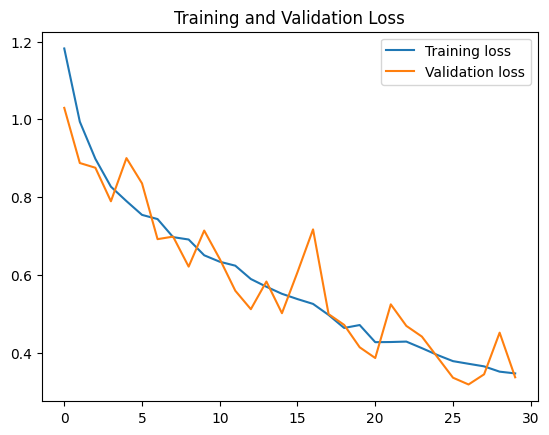

In [22]:
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")
plt.show()

In [23]:
model_version = 2
model.save(f"../outputs/{model_version}")

INFO:tensorflow:Assets written to: ../outputs/2\assets


INFO:tensorflow:Assets written to: ../outputs/2\assets


In [24]:
model = tf.keras.models.load_model("../outputs/1")

In [ ]:
for images_batch, labels_batch in test_set.take(1):
    displayed_image = images_batch[0].numpy().astype("uint8")
    image_label = labels_batch[0].numpy()
    
    print("Checking...")
    plt.imshow(displayed_image)
    plt.axis("off")
    image_prediction = model.predict(images_batch)
    actual = class_names[np.argmax(image_prediction[0])]
    predicted = class_names[image_label]
    print("Predicted label: ", actual)
    print("Actual label:", predicted)
    
    if actual == predicted:
        print("\nPrediction matches!")
    else:
        print("\nWrong prediction!")

#### Predicting on directory of new test images

In [28]:
gt = "../data/testing_images/glioma"
mg = "../data/testing_images/meningioma"
nt = "../data/testing_images/notumor"
p = "../data/testing_images/pituitary"

g_t = os.listdir(gt)
m_g = os.listdir(mg)
n_t = os.listdir(nt)
p_t = os.listdir(p)

class_labels = ["glioma", "meningioma", "notumor", "pituitary"]

In [29]:
g_label = [0] * len(g_t)
m_label = [1] * len(m_g)
n_label = [2] * len(n_t)
p_label = [3] * len(p_t)

label = g_label + m_label + n_label + p_label

In [30]:
data = []

for img in g_t:
    image = Image.open("../data/testing_images/glioma/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)
    
for img in m_g:
    image = Image.open("../data/testing_images/meningioma/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)
    
for img in n_t:
    image = Image.open("../data/testing_images/notumor/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)
    
for img in p_t:
    image = Image.open("../data/testing_images/pituitary/" + img).convert('RGB')
    image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    image = np.array(image)
    data.append(image)

In [31]:
X = np.array(data)
y = np.array(label)

X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.001)

print(X_train.shape)
print(y_train.shape)

(854, 224, 224, 3)
(854,)


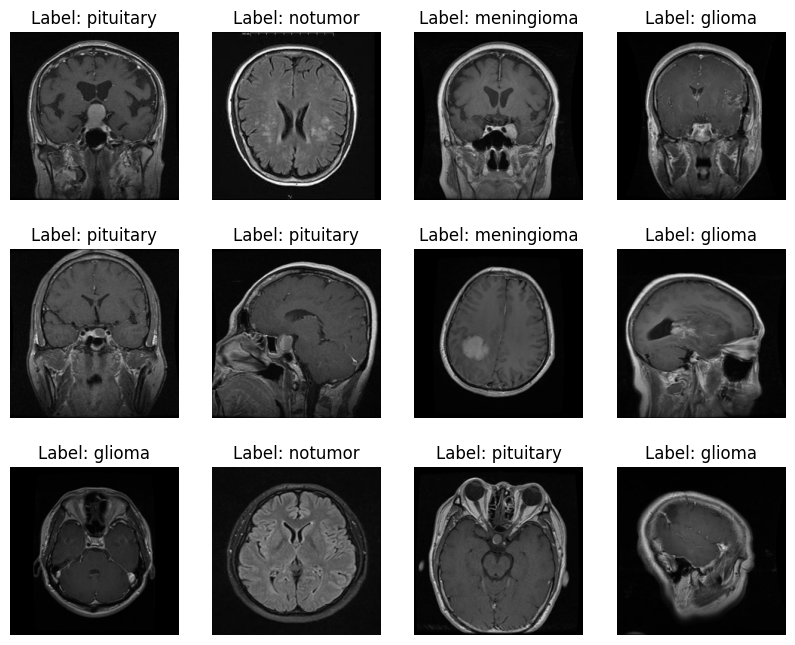

In [32]:
plt.figure(figsize=(10, 8))
for i in range(0, 12):
        plt.subplot(3, 4, i+1)
        plt.imshow(X_train[i])
        plt.title(f"Label: {class_labels[y_train[i]]}")
        plt.axis("off")

In [33]:
y_pred = model.predict(X_train)
y_pred_label = [np.argmax(i) for i in y_pred]

27/27 [==============================] - 16s 594ms/step


In [ ]:
a = y_pred_label[:]
np.hstack(a)
b = y_train[:]
a == b

In [35]:
elem = 0
for x, y in zip(a, b):
    if x == y:
        elem += 1
print(f"Correctly predicted {elem} out of {len(a)} test images.")
print(f"{(elem / len(a)) * 100} %")

Correctly predicted 758 out of 854 test images.
88.75878220140515 %


Correctly predicted 53 out of 60 displayed test images,
7 incorrect predictions


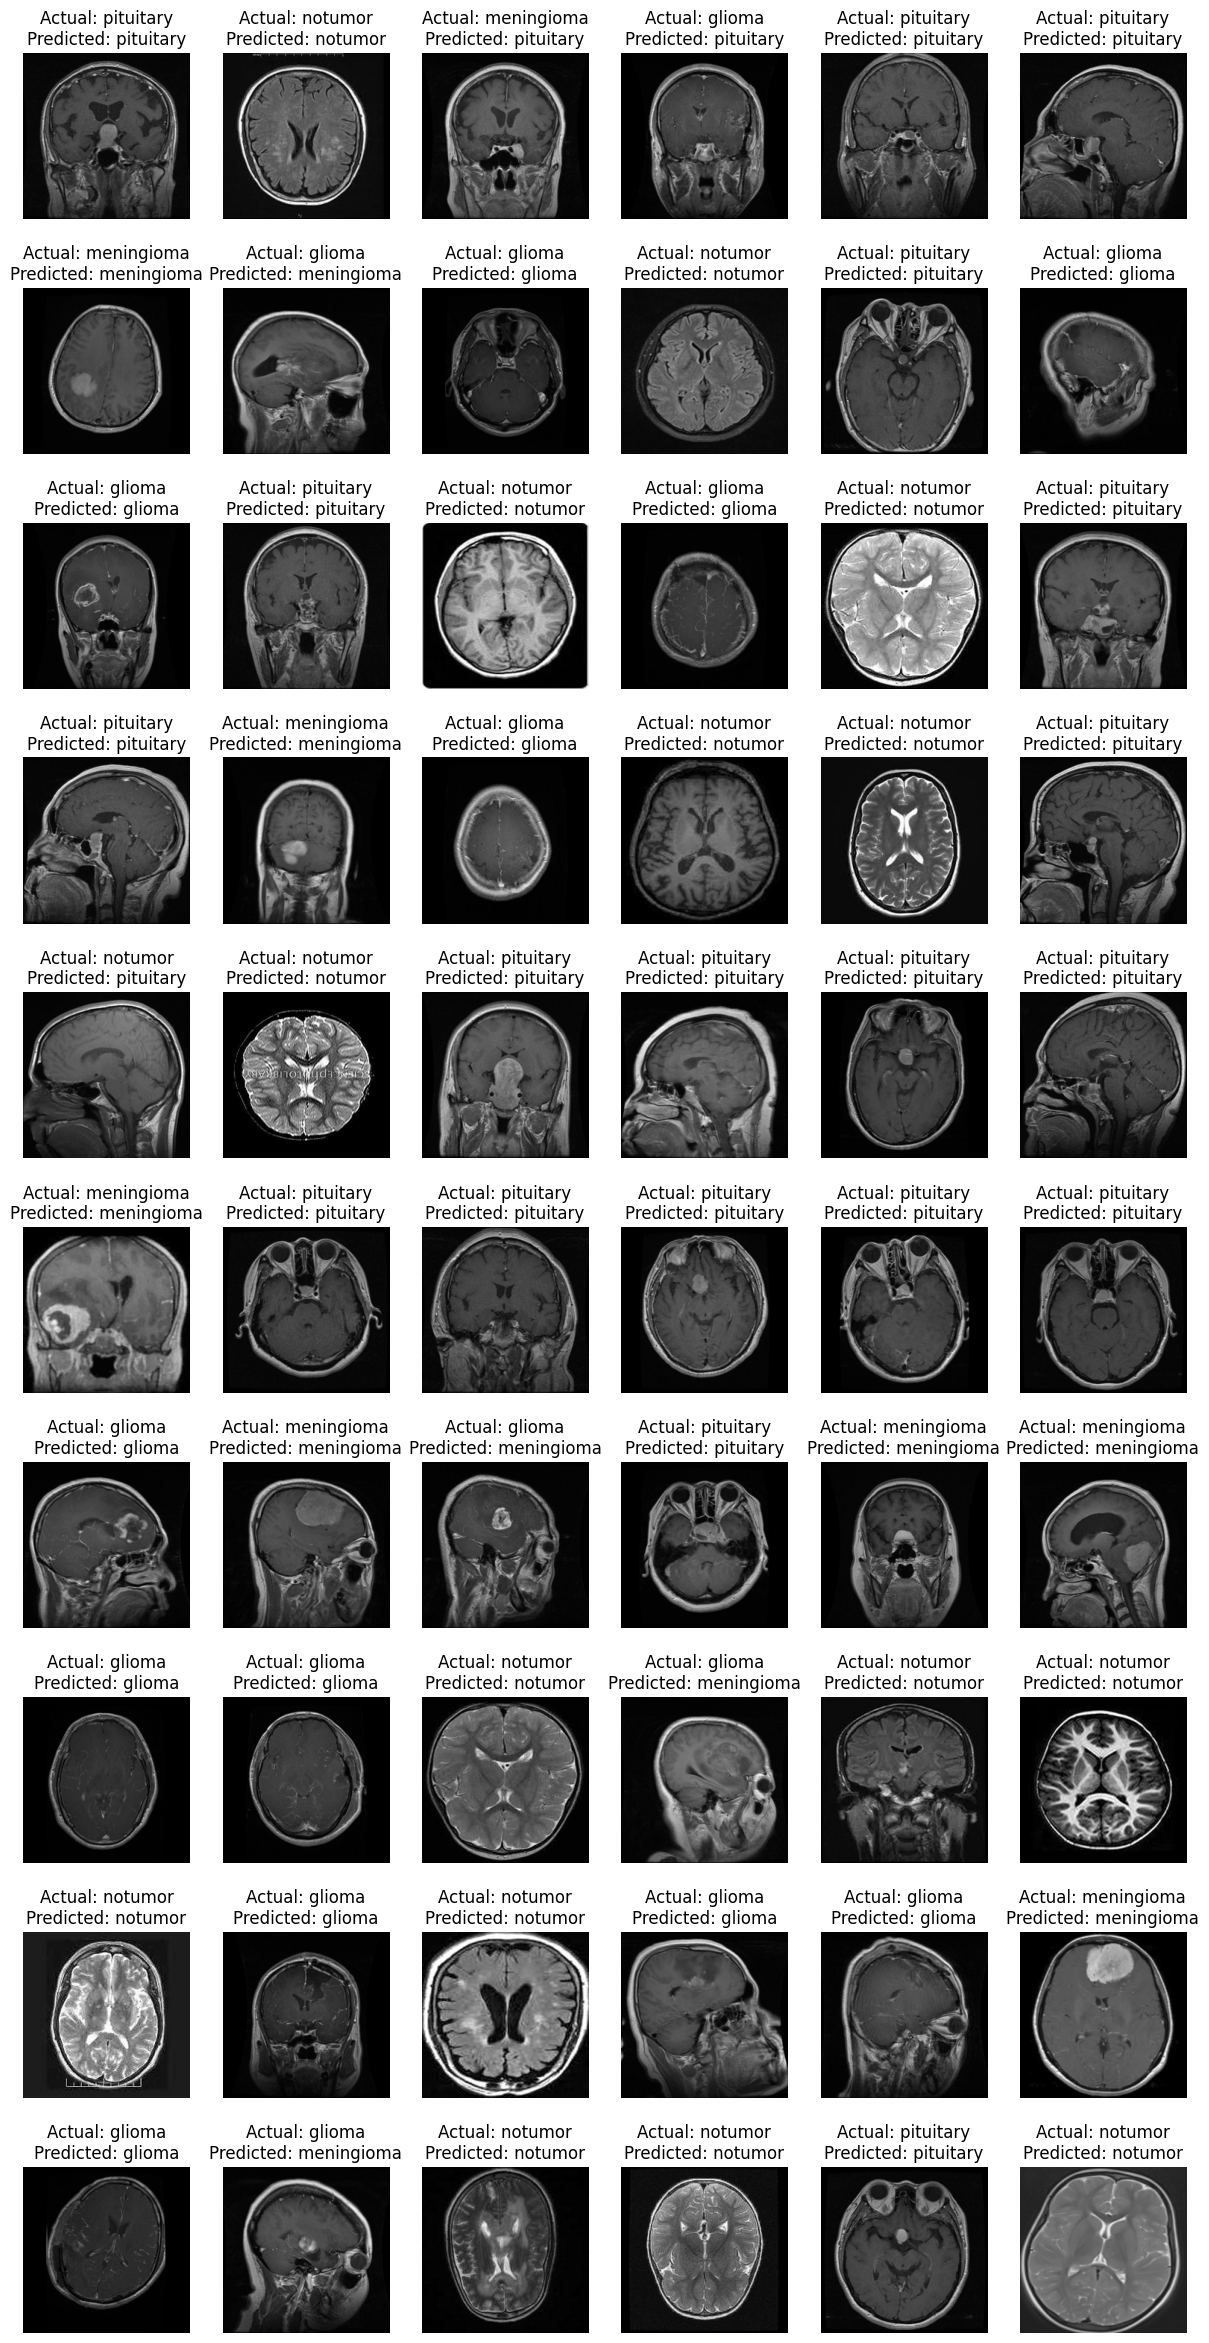

In [36]:
correct_count = 0
total = 60
incorrect_count = 0

plt.figure(figsize=(15, 30))
for i in range(0, total):
    plt.subplot(10, 6, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Actual: {class_labels[y_train[i]]}\nPredicted: {class_labels[y_pred_label[i]]}")
    plt.axis("off")
    if class_labels[y_train[i]] == class_labels[y_pred_label[i]]:
        correct_count += 1
    else:
        incorrect_count += 1
print(f"Correctly predicted {correct_count} out of {total} displayed test images,\n{incorrect_count} incorrect predictions")